In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [4]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import Lasso

In [5]:
#!pip install imblearn 

In [6]:
seed = 42
np.random.seed(seed)

# Import Merged Data

In [7]:
cm = pd.read_csv('Merged_1985-2019.csv')

In [8]:
cm.head()

,tic,conm,LPERMNO,fyear,ni,dv,fincf,ivncf,oancf,ch,gp,xint,lct,dltt,xrent,prcc_f,che,cstkcv,PERMNO,bankrupt,year,quarter
0,AMFD.,A & M FOOD SERVICES INC,10015,1985.0,2.576,0.0,NaN,NaN,NaN,1.688,40.268,1.726,13.922,11.908,1.263,10.125,2.787,NaN,10015,0.0,NaN,NaN
1,ANTQ,A.A. IMPORTING CO INC,10031,1985.0,0.236,0.0,NaN,NaN,NaN,0.005,10.330,0.273,2.643,4.682,1.211,4.500,0.005,0.1,10031,0.0,NaN,NaN
2,ANTQ,A.A. IMPORTING CO INC,10031,1986.0,0.793,0.0,NaN,NaN,NaN,0.241,17.189,0.448,3.378,3.750,2.267,4.500,0.241,0.1,10031,0.0,NaN,NaN
3,ANTQ,A.A. IMPORTING CO INC,10031,1987.0,0.186,0.0,1.744,-0.523,-0.987,0.475,13.589,0.502,2.921,5.478,2.337,2.750,0.475,0.1,10031,0.0,NaN,NaN
4,ANTQ,A.A. IMPORTING CO INC,10031,1988.0,-7.838,0.0,2.223,-0.296,-2.100,0.302,11.088,0.727,16.370,0.104,2.944,1.750,0.302,0.1,10031,0.0,NaN,NaN


# Lag one year ahead #

In [9]:
# year_lag = lag for x years 
# e.g. a row with 2018 data -- year_lag = 2 -- (2018) 2017 2016

def lag(data, year_lag = 2):

    # change the fyear to ascend within every LPERMNO
    data.sort_values(['LPERMNO', 'fyear'], ascending = [True, True], inplace = True)

    # remove irrelevant columns first
    df = data.drop(columns = ['PERMNO','bankrupt','quarter','year'])
    
    # get the columns
    columns = df.columns
    col_to_lag = columns[3:]

    # run the loops to create lag columns to the number of lagged year
    for lag in range(1, year_lag+1):
        for colname in col_to_lag:
            df[f'{colname}'+ '_lag' + f'{lag}'] = df[f'{colname}'].shift((lag-1))

    # add back the bankrupt info
    df['bankrupt'] = data['bankrupt']
    df['year'] = data['year']
    df['quarter'] = data['quarter']

    # keep the new lagged columns and remove the original one
    df.drop(col_to_lag, axis=1, inplace = True)

    # drop the last row of each LPERMNO after lagging one year
    df = df.groupby(['LPERMNO']).apply(lambda x: x.iloc[1:])
    df = df.set_index('LPERMNO').reset_index()    
    
    # identify the real bankrupt row
    for i in range(len(df)):
        if (df['bankrupt'][i] == 1) & (df['year'][i] - df['fyear_lag1'][i] == 1):
            df['bankrupt'][i] = 1
        else:
            df['bankrupt'][i] = 0

    df['predict_year'] = df['fyear_lag1']+1

    return df

# cmcm = lag(cm[cm['tic'] == 'TSLA'],2)
cmcm = lag(cm ,2)
cmcm.head()

,LPERMNO,tic,conm,fyear_lag1,ni_lag1,dv_lag1,fincf_lag1,ivncf_lag1,oancf_lag1,ch_lag1,gp_lag1,xint_lag1,lct_lag1,dltt_lag1,xrent_lag1,prcc_f_lag1,che_lag1,cstkcv_lag1,fyear_lag2,ni_lag2,dv_lag2,fincf_lag2,ivncf_lag2,oancf_lag2,ch_lag2,gp_lag2,xint_lag2,lct_lag2,dltt_lag2,xrent_lag2,prcc_f_lag2,che_lag2,cstkcv_lag2,bankrupt,year,quarter,predict_year
0,10001,EGAS,GAS NATURAL INC,1987.0,0.312,0.416,NaN,NaN,NaN,NaN,1.083,0.303,1.983,2.750,NaN,5.875,0.729,0.15,1986.0,0.669,0.365,NaN,NaN,NaN,NaN,1.895,0.332,2.259,2.946,NaN,6.000,0.746,0.15,0.0,NaN,NaN,1988.0
1,10001,EGAS,GAS NATURAL INC,1988.0,0.564,0.427,NaN,NaN,NaN,NaN,1.422,0.311,1.894,2.555,NaN,6.250,0.744,0.15,1987.0,0.312,0.416,NaN,NaN,NaN,NaN,1.083,0.303,1.983,2.750,NaN,5.875,0.729,0.15,0.0,NaN,NaN,1989.0
2,10001,EGAS,GAS NATURAL INC,1989.0,1.208,0.459,3.887,-5.687,1.772,1.177,3.054,0.651,2.725,7.370,NaN,7.000,1.177,0.15,1988.0,0.564,0.427,NaN,NaN,NaN,NaN,1.422,0.311,1.894,2.555,NaN,6.250,0.744,0.15,0.0,NaN,NaN,1990.0
3,10001,EGAS,GAS NATURAL INC,1990.0,1.131,0.523,-0.559,-1.156,1.894,1.356,3.320,0.835,2.264,7.175,NaN,9.750,1.356,0.15,1989.0,1.208,0.459,3.887,-5.687,1.772,1.177,3.054,0.651,2.725,7.370,NaN,7.000,1.177,0.15,0.0,NaN,NaN,1991.0
4,10001,EGAS,GAS NATURAL INC,1991.0,1.073,0.594,-0.562,-1.152,1.954,1.595,3.168,0.775,2.215,6.965,NaN,10.500,1.595,0.15,1990.0,1.131,0.523,-0.559,-1.156,1.894,1.356,3.320,0.835,2.264,7.175,NaN,9.750,1.356,0.15,0.0,NaN,NaN,1992.0


In [10]:
cmcm['bankrupt'].value_counts()

0.0    203098
1.0       510
Name: bankrupt, dtype: int64

In [11]:
cmcm[cmcm['predict_year'] != 2020]['bankrupt'].value_counts()

0.0    201136
1.0       510
Name: bankrupt, dtype: int64

# Oversampling and Undersampling

In [12]:
def oversampling(data, y_label, k = 5, seed = 1):
    
    from imblearn.over_sampling import SMOTE

    X = data.loc[:, data.columns != y_label]
    y = data[y_label]

    sm = SMOTE(sampling_strategy = 'auto', k_neighbors = k, random_state = seed)

    X_res, y_res = sm.fit_resample(X, y)
    
    return X_res, y_res


def undersampling(data, y_label, n = 3):

    from imblearn.under_sampling import NearMiss

    X = data.loc[:, data.columns != y_label]
    y = data[y_label]

    nm = NearMiss(sampling_strategy = 'auto')

    X_res, y_res = nm.fit_resample(X, y)
    
    return X_res, y_res

# Cross Validation 

In [13]:
def model_cross_validation(model,X,y,K):
    X = X.to_numpy()
    y = y.to_numpy()
    kf = KFold(K,shuffle=True)
    folds = list(kf.split(X))
    train_performance = np.empty(K)
    validation_performance = np.empty(K)
    
    for idx in range(K):
        train,validation = folds[idx] # this give us the indexes of train and validation datapoints in current fold
        X_train = X[train]
        y_train = y[train]
        model.fit(X_train,y_train)
        train_accuracy = np.average(model.predict(X_train) == y_train)
        X_validation = X[validation]
        y_validation = y[validation]
        validation_accuracy = np.average(model.predict(X_validation)==y_validation)
        train_performance[idx] = train_accuracy
        validation_performance[idx] = validation_accuracy
    return train_performance,validation_performance

cross_validation = {}
kfolds = 10

# Lasso Regression 

In [14]:
# lasso = Lasso()

# parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1 , 2, 3, 5, 10, 20]}
# # once we know best range of alpha we can scope it down

# lasso_regressor = GridSearchCV(lass, parameters, scoring = 'neg_mean_squared_error', cv = 5)

# lasso_regressor.fit(X,y)

# lasso_regressor.best_params_
# lasso_regressor.best_score_

# Base model #

### Plan 1: Drop all the missing values. Change all the 0 value to a small number. Only 99283 rows left, abount 50% of the data.

In [15]:
cm1 = cmcm.dropna(subset= cmcm.columns[4:33])
cm1[cm1['predict_year'] != 2020]['bankrupt'].value_counts()

0.0    98422
1.0      302
Name: bankrupt, dtype: int64

In [16]:
cm1_sm = cm1.drop(['LPERMNO','tic','conm', 'year', 'quarter','fyear_lag1','fyear_lag2'],axis=1)
print(cm1_sm['bankrupt'].value_counts())

x, y = oversampling(cm1_sm, 'bankrupt')
x = x.drop(['predict_year'],axis = 1)
cm1_smote = pd.merge(x, y, left_index = True, right_index = True)
cm1_smote['bankrupt'].value_counts()

0.0    98981
1.0      302
Name: bankrupt, dtype: int64


1.0    98981
0.0    98981
Name: bankrupt, dtype: int64

## Logistic model without scaling

In [17]:
def Logistic_model_without_scaling(x,y,train_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train_size)
    return x_train, x_test, y_train, y_test

In [18]:
x_train, x_test, y_train, y_test = Logistic_model_without_scaling(x,y,0.3)
model = LogisticRegression()
train_performance,validation_performance = model_cross_validation(model,x_train,y_train,kfolds)
cross_validation['Logistic model without scaling'] = (np.mean(train_performance), np.mean(validation_performance))

## Logistic model with scaling

In [19]:
def Logistic_model_with_scaling(x,y,train_size):
    scaler = StandardScaler()
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train_size)
    return x_train, x_test, y_train, y_test

In [20]:
x_train, x_test, y_train, y_test = Logistic_model_with_scaling(x,y,0.3)
model = LogisticRegression()
train_performance,validation_performance = model_cross_validation(model,x_train,y_train,kfolds)
cross_validation['Logistic model with scaling'] = (np.mean(train_performance), np.mean(validation_performance))

## Logistic model using categorical variables

In [21]:
def Logistic_model_using_categorical_vraibles(x,y,train_size):
    # I use the data without scaling because it performs better than with scaling.
    # dv, dltt, cstkcv can not be divided into 10 different groups so I will deal with others first.
    x1 = x.copy().drop(['dv_lag1','dv_lag2','dltt_lag1','dltt_lag2','cstkcv_lag1','cstkcv_lag2'],axis=1)
    
    # Categorical from 1 to 10 (so in the future maybe we can set NA and inf to 0)
    for col in x1.columns:
        x1[col] = pd.qcut(x1[col],10,labels=np.arange(1,11))
    
    x2 = x.copy()[['dv_lag1','dv_lag2','dltt_lag1','dltt_lag2','cstkcv_lag1','cstkcv_lag2']]
    # They can only be divided into 3 categories.
    for col in x2.columns:
        x2[col] = pd.qcut(x2[col],3,labels=np.arange(1,4))
        
    x = x2.join(x1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train_size)
    return x_train, x_test, y_train, y_test

In [22]:
x_train, x_test, y_train, y_test = Logistic_model_using_categorical_vraibles(x,y,0.3)
model = LogisticRegression()
train_performance,validation_performance = model_cross_validation(model,x_train,y_train,kfolds)
cross_validation['Logistic model using categorical variables'] = (np.mean(train_performance), np.mean(validation_performance))

In [23]:
cross_validation

{'Logistic model without scaling': (0.8553654733000331, 0.8539434372956766),
 'Logistic model with scaling': (0.8591840473335475, 0.8589445570780196),
 'Logistic model using categorical variables': (0.8945522109752352,
  0.8944567541420179)}

In [24]:
cross_validation_results = {k: v for k, v in sorted(cross_validation.items(), key=lambda item: item[1], reverse=True)}
best_model = list(cross_validation_results.keys())[0] 
best_model

'Logistic model using categorical variables'

# Result with Best Model

In [25]:
x_train, x_test, y_train, y_test = Logistic_model_using_categorical_vraibles(x,y,0.3)
model = LogisticRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.90527   0.88098   0.89296     69122
         1.0    0.88463   0.90825   0.89628     69452

    accuracy                        0.89465    138574
   macro avg    0.89495   0.89462   0.89462    138574
weighted avg    0.89492   0.89465   0.89463    138574



<Figure size 432x288 with 0 Axes>

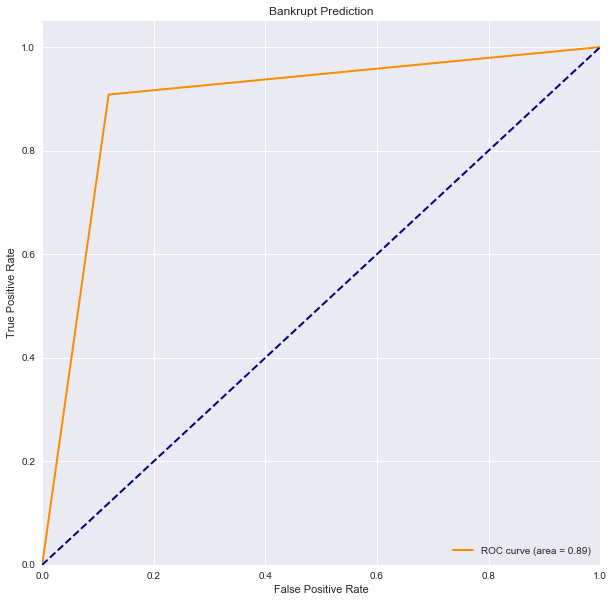

In [26]:
fpr,tpr,threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bankrupt Prediction')
plt.legend(loc="lower right")
plt.show()

# Exploratory Data Analysis #

In [27]:
#! pip install pandas-profiling

In [28]:
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(cm1)
# profile.to_file(outputfile = 'Profile.html')
# profile